# Galaxy Recognition challenge

In [1]:
import os
import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr

from skimage.transform import resize
from skimage import io

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!unzip -q /kaggle/input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip
!unzip -q /kaggle/input/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.zip
!unzip -q /kaggle/input/galaxy-zoo-the-galaxy-challenge/images_test_rev1.zip

In [3]:
#os.environ['KAGGLE_USERNAME'] = "rahulsathiyababu" # username from the json file
#os.environ['KAGGLE_KEY'] = "" # key from the json file

In [4]:
#!ls /kaggle/working

#!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge -f /kaggle/working/checkpoints

In [5]:
#!zip -r file.zip /kaggle/working/checkpoints

In [6]:
#from IPython.display import FileLink
#FileLink(r'/kaggle/working/file.zip')

#<a href="/kaggle/working/file.zip"> Download File </a>

In [7]:
#!rm training_solutions_rev1.zip
#!rm images_training_rev1.zip
#!rm -r sample_data

# Data Analysis

In [8]:
df = pd.read_csv('/kaggle/working/training_solutions_rev1.csv')

In [9]:
#df

In [10]:
# Based on https://www.kaggle.com/helmehelmuto/keras-cnn
# but uses float32 to save memory/space

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    return x
    
def get_train_data(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:].astype(np.float32)
    x_batch = []
    for i in tqdm(ids):
        x = get_image('/kaggle/working/images_training_rev1/'+i+'.jpg', x1, y1, shape=shape, crop_size=crop_size)
        x_batch.append(x.astype(np.float32))
    x_batch = np.array(x_batch)
    return x_batch, y_batch

%time x, y = get_train_data(df)

100%|██████████| 61578/61578 [08:08<00:00, 125.98it/s]


CPU times: user 8min 1s, sys: 8.57 s, total: 8min 9s
Wall time: 8min 12s


In [11]:
# Don't change the numbers in this command!
x, x_test, y, y_test = train_test_split(x, y, train_size=0.89391, random_state=99765749)

In [12]:
print("shape of the data array: {}".format(x.shape))
print("shape of the label array: {}".format(y.shape))

shape of the data array: (55045, 64, 64, 3)
shape of the label array: (55045, 37)


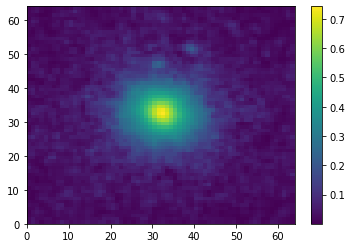

In [13]:
plt.pcolormesh(x[4,:,:,1])
plt.colorbar()

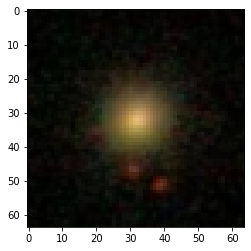

In [14]:
plt.imshow(x[4])
plt.show()

---
## Test metric definition
Before we let you start coding stuff, we will define a scoring function. If you want to use this same metric for the optimisation of the network: it is called the *Root Mean Squared Error*.

In [15]:
def score(y_prediction):
  return np.sqrt(np.mean( np.power(y_prediction - y_test, 2) ))

In [16]:
# Imports first
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2


In [17]:
model = Sequential()

#model.add(Conv2D(32,3,activation='relu', input_shape = (x.shape[1],x.shape[2],x.shape[3]),kernel_regularizer='l2'))
model.add(Conv2D(32,3,activation='relu', input_shape = (64,64,3),kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(64,3,activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128,3,activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(512,3,activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())

#model.add(Conv2D(512,(4,4),activation='relu'))
model.add(GlobalMaxPooling2D())

#model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(37,activation= 'sigmoid'))

2022-04-22 19:01:09.008782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 19:01:09.014011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 19:01:09.014715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 19:01:09.015916: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [19]:
model.compile(optimizer='adam',loss='mse',metrics=['RootMeanSquaredError'])
model.save_weights('/kaggle/working/checkpoints/my_checkpoint')

In [20]:
history = model.fit(x,y,batch_size=128, epochs=7, validation_data=(x_test,y_test))

2022-04-22 19:01:19.767651: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2705571840 exceeds 10% of free system memory.
2022-04-22 19:01:22.473474: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2705571840 exceeds 10% of free system memory.
2022-04-22 19:01:24.528180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2022-04-22 19:01:26.232109: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


431/431 [==============================] - ETA: 0s - loss: 0.1567 - root_mean_squared_error: 0.1626

2022-04-22 19:01:38.106737: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 321110016 exceeds 10% of free system memory.
2022-04-22 19:01:38.264604: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 321110016 exceeds 10% of free system memory.


431/431 [==============================] - 14s 17ms/step - loss: 0.1567 - root_mean_squared_error: 0.1626 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2275
Epoch 2/7
431/431 [==============================] - 7s 16ms/step - loss: 0.0243 - root_mean_squared_error: 0.1354 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2160
Epoch 3/7
431/431 [==============================] - 7s 17ms/step - loss: 0.0215 - root_mean_squared_error: 0.1305 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1299
Epoch 4/7
431/431 [==============================] - 7s 16ms/step - loss: 0.0200 - root_mean_squared_error: 0.1284 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1766
Epoch 5/7
431/431 [==============================] - 7s 16ms/step - loss: 0.0200 - root_mean_squared_error: 0.1284 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1787
Epoch 6/7
431/431 [==============================] - 7s 16ms/step - loss: 0.0192 - root_mean_squared_error: 0.1265 - val_loss: 0.0283 - val_root_mean

In [21]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['train', 'val'], loc='upper right')
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.show()

In [22]:
# plt.plot(history.history['root_mean_squared_error'])
# plt.plot(history.history['val_root_mean_squared_error'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.legend(['train', 'val'], loc='upper right')
# plt.xlabel('epoch')
# plt.show()

In [23]:
#model.load_weights('/kaggle/working/checkpoints/my_checkpoint')

# Prediction 1st way

In [24]:
# image_name_list = os.listdir('/kaggle/working/images_test_rev1')
# ORIG_SHAPE = (424,424)
# CROP_SIZE = (256,256)
# IMG_SHAPE = (64,64)

# def get_image(path, x1,y1, shape, crop_size):
#     x = plt.imread(path)
#     x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
#     x = resize(x, shape)
#     return x

# id_list=[]
# x_batch =[]
# x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
# y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2

# for f in image_name_list:
    
#     x = get_image('/kaggle/working/images_test_rev1/'+f, x1, y1, shape=IMG_SHAPE, crop_size=CROP_SIZE)
#     x_batch.append(x.astype(np.float32))
#     id_list.append(int(os.path.splitext(f)[0]))
        
# id_list = np.array(id_list)
# x_batch= np.array(x_batch)

In [25]:
# y_prediction = model.predict([x_batch])
# #fres = np.concatenate((gid,y_prediction))
# fres = np.column_stack((id_list,y_prediction))
# result= pd.DataFrame(fres, columns=df.columns)
# result =result.astype({"GalaxyID": int}, errors='raise')
# result.sort_values(by=['GalaxyID'])
# result.to_csv('submission.csv',index=False)

# Prediction 2nd way

In [26]:
import os
from tqdm import tqdm
batch_size = 128
def test_image_generator(ids, shape=IMG_SHAPE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
    x_batch = []
    for i in ids:
        x = get_image('/kaggle/working/images_test_rev1/'+i, x1, y1, shape=IMG_SHAPE, crop_size=CROP_SIZE)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch

val_files = os.listdir('/kaggle/working/images_test_rev1/')
val_predictions = []
N_val = len(val_files)
for i in tqdm(np.arange(0, N_val, batch_size)):
    if i+batch_size > N_val:
        upper = N_val
    else:
        upper = i+batch_size
    X = test_image_generator(val_files[i:upper])
    y_pred = model.predict(X)
    val_predictions.append(y_pred)
val_predictions = np.array(val_predictions)
Y_pred = np.vstack(val_predictions)
ids = np.array([v.split('.')[0] for v in val_files]).reshape(len(val_files),1)
submission_df = pd.DataFrame(np.hstack((ids, Y_pred)), columns=df.columns)
submission_df = submission_df.sort_values(by=['GalaxyID'])
submission_df.to_csv('submission.csv', index=False)

100%|██████████| 625/625 [11:15<00:00,  1.08s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
